# Introduction to Neural Networks for Classification with neuralnet and TensorFlow/Keras

For this tutorial we'll classify audio data by emotions. I chose audio data because it hits three birds with one stone: Classifying audio data is the same as classifying images, which is the same as classifying any vector of numbers.

## Goals:
- Demonstrate classification of various data types with Neural Networks
- Provide examples of two different approaches to data management for networks
- Introduce the basics of evaluating and tuning a model

# Intro and Data

In [1]:
library(neuralnet)
# imager will be used for importing and manipulating data.
library(imager)

Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




This is the data source. It's from the Toronto Emotional Speech Set. The set consists of both old adult female (OAF) and young adult female (YAF) voice samples saying various words with specific emotions. We'll work with the happy and angry samples

In [2]:
# these are just to play the audio sample below
library(shiny)
library(IRdisplay)

tags$audio(src = 'OAF_back_happy.wav', type = 'audio/wav', controls = NA)


Attaching package: ‘IRdisplay’


The following object is masked from ‘package:imager’:

    display




Shiny tags cannot be represented in plain text (need html)

For classification we convert the audio data to a mel spectrogram. Below is a spectrogram of the same audio sample. There's a bit of pre-processing to convert the audio, but it's not terribly complicated and we're going to skip over this since it's not the focus. The torchaudio library has functions for this in R, and librosa and Pytorch can do it in Python.

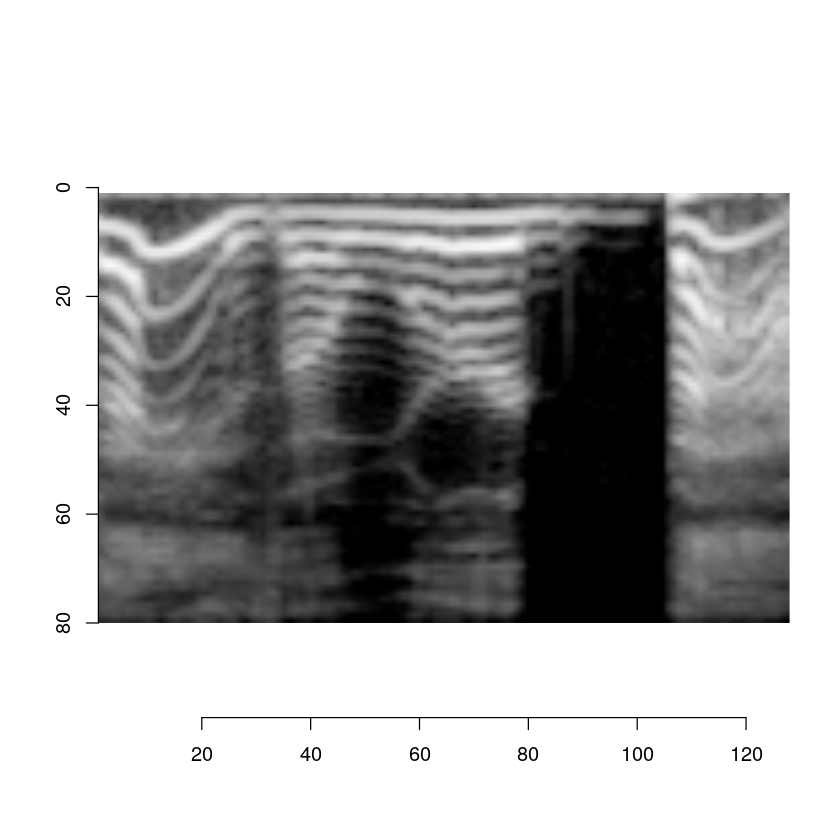

In [3]:
# load a sample image with imager
sample <- load.image('happy/H_OAF_back.png')
plot(sample)

This image is actually just a vector of pixel values. Each pixel is a number between zero and one that represents how dark that pixel is. Each image is an observation, and each pixel value can be thought of as a variable for that observation. It's no different from polity, GDP, average rainfall, or any other variable you might use in a model. What's neat is that you can actually play audio directly from this image. The audio data and the pixel values are largely the same!

In [4]:
# here are the first 10 pixel values
sample[1:10]

[1] 0.6039216 0.5882353 0.5137255 0.5254902 0.5882353 0.5921569 0.6039216
 [8] 0.6039216 0.5882353 0.6000000

In order to reduce the features in our data, we're going to resize the image to reduce the pixel count. This wouldn't sound recognizable anymore if we played it, but it should still be enough data for our model.

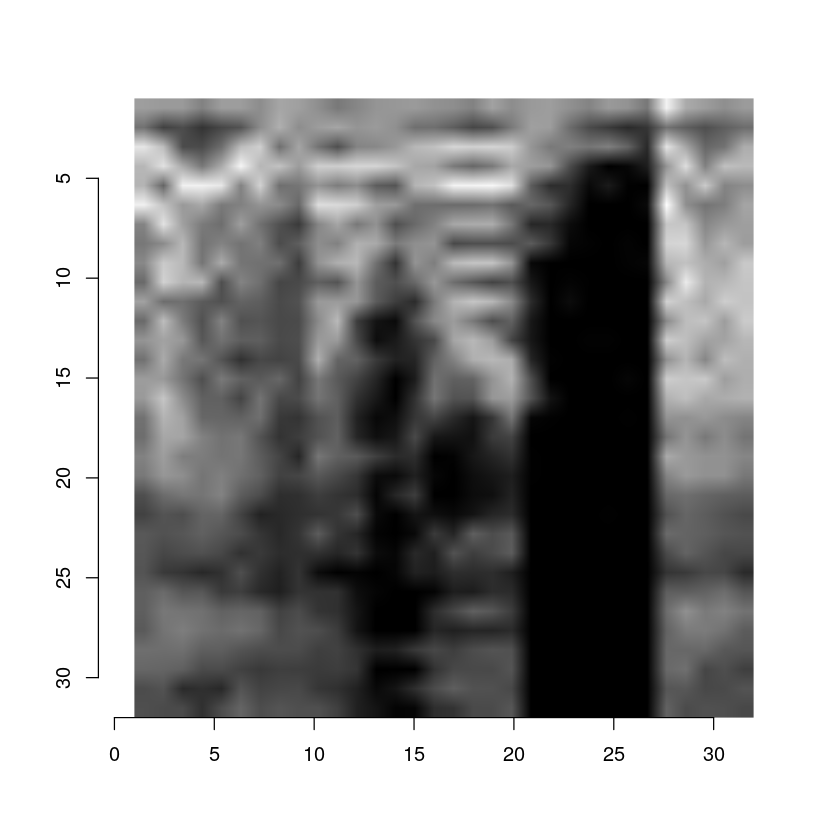

In [13]:
sample <- resize(sample, 32, 32)
plot(sample)

## Data prep

We'll start with a familiar data structure by importing all of the images and adding their numeric vectors to a data frame.

In [80]:
# set the desired dimensions we will convert the images to
dim1 <- 32
dim2 <- 32

# list images in the happy directory
happy <- list.files('happy', full.names=T)


# instantiate the data frame
happy_df <- data.frame()

# generate column names for the data frame based on the number of pixels in the image
# these pimages will be 64*64 = 4096 pixels. So i create columns named px1......px4096
col_names <- sapply('px', paste, seq(dim1*dim2), sep='')

# load each image, resize it, and then add the vector to the data frame
for(file in happy){
    img <- load.image(file)
    img <- resize(img, dim1, dim2)
    happy_df <- rbind(happy_df, img)
}

# set the column names
colnames(happy_df) <- col_names

# add a label to the data. Happy will be 1 and angry 0
happy_df$label <- 1

Now we just repeat the above with the angry data

In [81]:
# list images in the directory
angry <- list.files('angry', full.names=T)

# instantiate the data frame
angry_df <- data.frame()
# generate column names
col_names <- sapply('px', paste, seq(dim1*dim2), sep='')

# load each image, resize it, and then add the vector to the data frame
for(file in angry){
    img <- load.image(file)
    img <- resize(img, dim1, dim2)
    angry_df <- rbind(angry_df, img)
}
# set the column names
colnames(angry_df) <- col_names

# add a label to the data
angry_df$label <- 0

In [82]:
# combine both data sets
df <- rbind(happy_df, angry_df)

write.csv(df, 'pixels.csv')

# Classifying with neuralnet

neuralnet is a light-weight package that uses familiar syntax and data structures for constructing neural networks.

## Train-test split

Now we need to combine the data and split it in to a training and a test set. I'll use an 80:20 split.

In [83]:
df <- read.csv('pixels.csv')
# this will randomize the order of the data
set.seed(123)
df <- df[sample(1:width(df)),]

# now divide the data in to training and test sets
train <- df[1:592,]
test <- df[592:740,]

## Define and train the model

neuralnet uses the standard formula structure similar to glm() to define its model. The first layer of the model has as many neurons as there are features. In this case, 1024. That's too long of a formula to type out so the first line of code automates that for me.

The model I set up has tree hidden layers with a decreasing number of neurons in each. Constructing a network is part domain knowledge, and part trial and error. Think about what your task is, and then start with an educated guess. My task is a dimensionality reduction: Reduce 1024 pixels down to the single dimension of emotion. A common way to do this with a neural net is to pass the data through a bottleneck. This is a fairly common structure for classification and dimension reduction tasks. 

In [77]:
# define the formula
f <- as.formula(paste('label ~', paste(col_names, collapse = " + ")))

# train the network
set.seed(123)
nn <- neuralnet(f, data=train, hidden = c(128, 16, 8), linear.output = FALSE)

Time difference of 1.888807 secs


Now lets see how the model preformed. The model assigns a continuous value rather than a binary classification for each observation.

In [78]:
# drop the label from the test set so the network can predict it
nn_test <- subset(test, select=-c(label))

# predict labels for the test set
results <- compute(nn, nn_test)

# Create a data frame of true labels and results
r_df <- data.frame(actual=test$label, prob = results$net.result)

Based on the predicted value, we assign predicted labels. The model achieved over 97% accuracy.

In [79]:
# If the predicted value is over, .5 label happy happy, otherwise angry
r_df$pred <- ifelse(r_df$prob > 0.5, 1, 0)
# flag correct predictions
r_df$correct <- ifelse(r_df$pred == r_df$actual, 1, 0)
# calculate the accuracy of predictions
sum(r_df$correct)/width(r_df)

[1] 0.9798658

# TensorFlow and Keras

Tensorflow and PyTorch are the two libraries that form the backbone of modern deep learning. Both have R implementations, although Tensorflow's implementation is more developed. Keras is a library that provides a fast and easy interface for TensorFlow. Be aware that most of the help you'll find online will be about Python. Don't worry! The syntax is nearly identical and most of what you'll find is transferable with minor tweaks and reference to the documentation.  

These libraries offer a few significant advantages:
- Fully customizable neural networks with a large variety of architectures
- Lots of tools for handling and manipulating data
- GPU acceleration
- Tools for optimizing models and saving training progress
- Interfaces with pre-trained models for transfer learning

Consider using Tensorflow or Torch if:
- You require a GPU
- Plan on using a pre-trained model
- You're working with complex data such as RGB photos, audio, or video


A quick note about hardware: Neural networks are often too large to be feasibly trained on a CPU. A GPU can speed this up by several orders of magnitude. To train on a GPU you need either a desktop computer with an Nvidia GPU or access to one via the cloud. Google Colab offers free access to GPUs for ~2 hour intervals. If you need a GPU for longer training times talk with your advisor about getting access to Penn State's CyberLAMP. 

In [ ]:
# Run these commands in a console in order to install Tensorflow with Keras
install.packages('tensorflow')
library(tensorflow)
install_tensorflow()

install.packages('keras')
library(tensorflow)
install_tensorflow()

In [1]:
# once installed, we can just import keras
library(keras)
# dplyr for the pipe operator
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Keras will handle the data steam a bit differently than base R and neuralnet. Rather than importing the data, manipulating it, and compiling it in a data frame, Keras can stream the data from its directory and feed it to the network. A common way to organize data for this process is to divide files in to training and test folders before importing it.

Keras can also use what are known as data generators. Generators take the original training data and preform some sort of systematic manipulation to it before feeding it to the network. For images you can do things like rotate and crop and image before passing it through the network. This allows you to use the same image several times when training the model and greatly increases the size of your data set, creating better results. We're just going to resize the image here.

In [54]:
# define the image size we want to use
img_size <- c(32, 32)
# define the batch size. This is the number of observations passed through the network before model parameters are updated
# Larger or smaller batch sizes will produce better/worse results depending on the model. 32 is a standard starting point.
# If your computer runs out of memory while training the model, try lowering the batch size.
batch_size <- 32


# Data Generator for Training Set. Keras infers the labels for the data based on the directory
train_image_array_gen <- flow_images_from_directory(directory = paste0(getwd(),"/keras/training/"),
                           target_size = img_size, 
                           color_mode = "grayscale", 
                           batch_size = batch_size,
                           seed = 123)

# Data Generator for Validation Set
validation_image_array_gen <- flow_images_from_directory(directory = paste0(getwd(),"/keras/test/"),
                           target_size = img_size, 
                           color_mode = "grayscale", 
                           batch_size = batch_size,
                           seed = 123)

# The number of files used by our training generator
n_train <- train_image_array_gen$n
# The number of files used by our validation generator
n_test <- validation_image_array_gen$n
# the number of categories in our data
n_cat <- 2

We're going to recreate the model we built in neuralnet. This is a basic feed forward network with fully connected (dense) layers and a logistic activation function. Because TensorFlow has many different possible types of layers, we need to define which kind we want more explicitly than in the neuralnet package.

In [189]:
# Define the type of model. Sequential is a linear feed forward model
model <- keras_model_sequential()

# Now we define each layer of the model
model %>%
    # The first layer needs to define the dimensions of the input data. In this case, a 32x32 matrix of pixel values
    layer_flatten(input_shape = c(32,32)) %>%
    # Now we add our dense layers. Units is the number of neurons and activation is the function used to determine
    # if neurons on the next layer are activated. The last layer uses a softmax function to return a value between
    # zero and one.
    layer_dense(units = 128, activation = 'sigmoid') %>%
    layer_dense(units = 16, activation = 'sigmoid') %>%
    layer_dense(units = 8, activation = 'sigmoid') %>%
    layer_dense(units = 2, activation = 'softmax')

Before we can train the model, we compile it and determine model parameters. Loss is a way for the model to measure how correct a classification is while training. The goal of training is to minimize loss. The optimizer is the function used by the model for adjusting the weights. The Adam optimizer is a good place to start. The 'lr' argument is the learning rate. This is a measure of how much the weights are adjusted at each training step. Finally we define the metric used for evaluating the models classification performance. Here I'll use accuracy for comparison's sake, but I recommend using validation loss as a default. 

In [190]:
# Compile the model
model %>% 
  compile(
    loss = "categorical_crossentropy",
    optimizer = optimizer_adam(lr = 0.001),
    metrics = "accuracy"
)

# print the model
model

Model
Model: "sequential_69"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_69 (Flatten)                (None, 1024)                    0           
________________________________________________________________________________
dense_268 (Dense)                   (None, 128)                     131200      
________________________________________________________________________________
dense_269 (Dense)                   (None, 16)                      2064        
________________________________________________________________________________
dense_270 (Dense)                   (None, 8)                       136         
________________________________________________________________________________
dense_271 (Dense)                   (None, 2)                       18          
Total params: 133,418
Trainable params: 133,418
Non-trainable params: 0
________

Now we can fit the model. When training we need to define the number of epochs (a complete pass through of the data) and steps (A pass through of one batch). More epochs does not necessarily mean a better model and the number that is ideal can range from one to thousands. 200 is often a default starting point. We'll just go with 10 here.

In [191]:
keras_nn <- model %>% 
    fit_generator(
    # Pass our training data generator
    train_image_array_gen,
  
    # Define the number of epochs as well as the steps per epoch.
    # since we want an epoch to be one complete pass through of the data, we set the
    # number of steps equal to the total number of samples divided by the batch size
    steps_per_epoch = as.integer(n_train/batch_size), 
    epochs = 10, 
  
    # Now we add the validation data
    validation_data = validation_image_array_gen,
    validation_steps = as.integer(n_test/batch_size),
  
    # print progress
    verbose = 2
)

To check the results we can call the model to print accuracy scores and plot it to see performance over time.

`geom_smooth()` using formula 'y ~ x'




Final epoch (plot to see history):
        loss: 0.6659
    accuracy: 0.5148
    val_loss: 0.6753
val_accuracy: 0.4922 

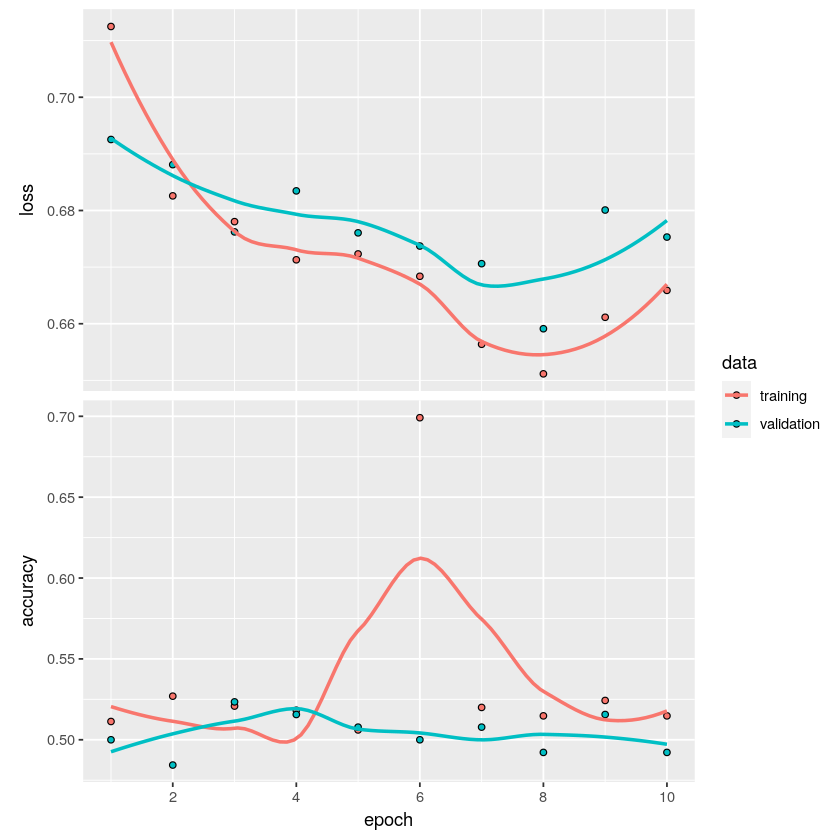

In [192]:
plot(keras_nn)
keras_nn

Looks like our model wasn't very good. Keras uses slightly different optimization algorithms and default parameters than neuralnet. My hunch is that our learning rate is too high and that the model would benefit from a few more neurons. Let's try lowering the learning rate and widening the bottleneck a bit

In [218]:
# Define the type of model. Sequential is a linear feed forward model
start <- Sys.time()
model <- keras_model_sequential()

# Now we define each layer of the model

model %>%
    # The first layer needs to define the dimensions of the input data. In this case, a 64x64 matrix of pixel values
    layer_flatten(input_shape = c(32,32)) %>%
    # Now we add our dense layers. Units is the number of neurons and activation is the function used to determine
    # if neurons on the next layer are activated.
    layer_dense(units = 512, activation = 'sigmoid') %>%
    layer_dense(units = 128, activation = 'sigmoid') %>%
    layer_dense(units = 16, activation = 'sigmoid') %>%
    layer_dense(units = 2, activation = 'softmax') 

# Compile the model
model %>% 
  compile(
    loss = "categorical_crossentropy",
    optimizer = optimizer_adam(lr = 0.0001),
    metrics = "accuracy"
)

# print the model
model
set.seed(0)

keras_nn2 <- model %>% 
    fit_generator(
    # Pass our training data generator
    train_image_array_gen,
  
    # Define the number of epochs as well as the steps per epoch.
    # since we want an epoch to be one complete pass through of the data, we set the
    # number of steps equal to the total number of samples divided by the batch size
    steps_per_epoch = as.integer(n_train/batch_size), 
    epochs = 15, 
  
    # Now we add the validation data
    validation_data = validation_image_array_gen,
    validation_steps = as.integer(n_test/batch_size),
  
    # print progress
    verbose = 2
)

finish <- Sys.time()
finish - start

Model
Model: "sequential_83"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_83 (Flatten)                (None, 1024)                    0           
________________________________________________________________________________
dense_324 (Dense)                   (None, 512)                     524800      
________________________________________________________________________________
dense_325 (Dense)                   (None, 128)                     65664       
________________________________________________________________________________
dense_326 (Dense)                   (None, 16)                      2064        
________________________________________________________________________________
dense_327 (Dense)                   (None, 2)                       34          
Total params: 592,562
Trainable params: 592,562
Non-trainable params: 0
________

Time difference of 4.447745 secs

`geom_smooth()` using formula 'y ~ x'




Final epoch (plot to see history):
        loss: 0.1496
    accuracy: 0.9965
    val_loss: 0.194
val_accuracy: 0.9922 

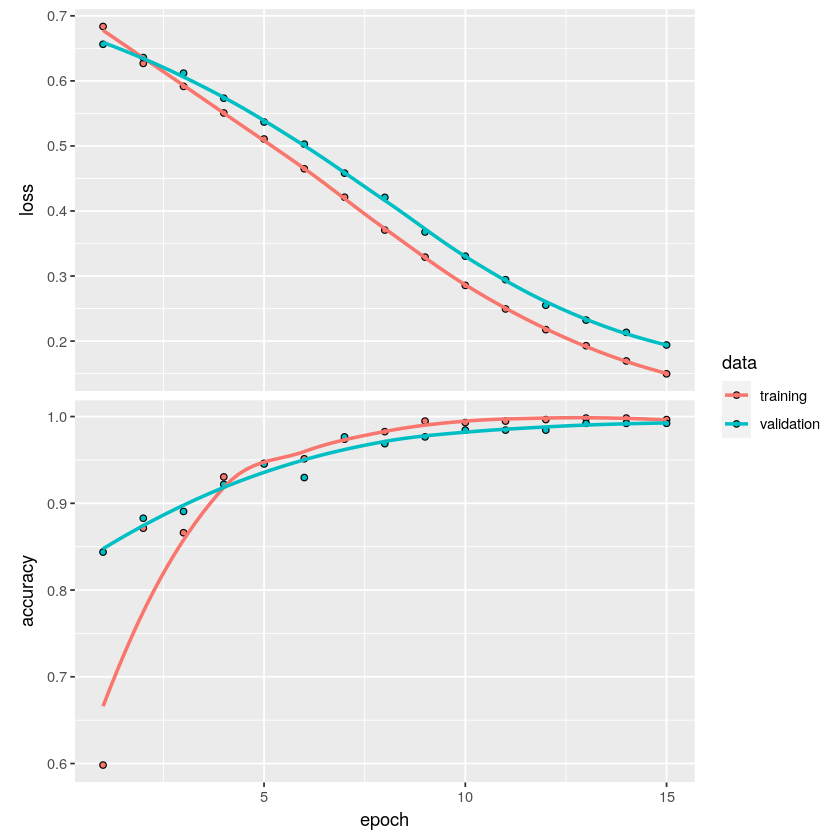

In [214]:
plot(keras_nn2)
keras_nn2

For basic tasks a few tweaks to the model can go a long way. For more complicated networks, there are dozens of hyperparameters you can adjust to optimize the model and thousands of different possible iterations. The number of training epochs and the learning rate are usually the best place to start when making adjustments. For more advanced tuning, you can use a Bayesian sweep which trains many versions of the model and updates parameters iteratively based on the results of previous trainings.

### Links

neuralnet docs: https://cran.r-project.org/web/packages/neuralnet/neuralnet.pdf

Keras docs: https://cran.r-project.org/web/packages/keras/keras.pdf

imager docs: https://cran.r-project.org/web/packages/imager/imager.pdf

TensorFlow for R: https://tensorflow.rstudio.com/

Keras for R: https://keras.rstudio.com/

Torch for R: https://torch.mlverse.org/